<a name="cell-TOC-opt"></a>

$\require{cancel}$

### 9. [Solving ](#cell-opt) [$\cancel{Ax=0}$](#cell-opt) [$f(x)=0$](#cell-opt)
  0. [Nonlinearity](#cell-opt-fx) [$b=f(x)\not=Ax$](#cell-opt-fx)
    0. [Minima, Maxima, and the Hessian](#cell-opt-fx-minmax) [$H_{f(\theta)}$](#cell-opt-fx-minmax)
        - [ Multivariate Taylor Series Approximations](#cell-opt-fx-mvtaylor)
    1. [The Jacobian](#cell-opt-jac) [$J$](#cell-opt-jac)   
    2. [The Score Function and MLE](#cell-opt-mles)
        - [Fisher Information](#cell-opt-fx-fi)
    3. [(Bayesian) Variational Inference](#cell-opt-VI)
        - [Kullback–Leibler (KL) divergence](#cell-opt-VI)
  1. [Nonlinear Root-Finding](#cell-opt-fx-solve) [$0=f(x)\not=Ax$](#cell-opt-fx-solve) 
    0. [Bisection](#cell-opt-fx-bisection)
        - [Initializations, Limitations, and Convergence](#cell-opt-fx-bisection-considerations)
    1. [Netwon's Method](#cell-opt-fx-newton)
        - [Order of Convergence](#cell-opt-fx-newton-conv) [$\beta$](#cell-opt-fx-newton)
        - [Ensuring Monotonic Iteration and Convergence](#cell-opt-fx-newton-like-ascent)
        - [Newton's Method for Mulitivariate Functions](#cell-opt-fx-newton-mulit): Week 9 Programming Assignment Problem 1
        - [Ensuring Monotonic Iteration and Convergence](#cell-opt-fx-newton-mulit-conv)

    2. [The Secant Method](#cell-opt-fx-secant)
        - [The Secant Method for Scalar Mulitivariate Functions](#cell-opt-fx-mvsecant)
    3. [Fixed-Point Iteration](#cell-opt-fx-fixedpoint): Week 9 Programming Assignment Problem 2

        - [[OMITTED] Contractive Mapping Theorem](#cell-opt-fx-fixedpoint-contraction)
        - [[OMITTED] Scaling](#cell-opt-fx-fixedpoint-scaling)
        - [Fixed-Point Iteration for Multivariate Functions](#cell-opt-fx-fixedpoint-mv)        
    4. [[OMITTED] Acceleration](#cell-opt-fx-acceleration)


> *Maximum likelihood estimation is central to statistical inference.  Long hours can be invested in learning about the theoretical performance of MLEs and their analytic derivation.  Faced with a complex likelihood lacking analytic solution, however, many people are unsure how to proceed.*
>
> *Most functions cannot be optimized analytically. ... Many realistic statistical models induce likelihoods that cannot be optimized analytically -- indeed, we would argue that greater realism is strongly assocaited with the reduced ability to find optima analytically.*
> 
> Geof Givens and Jennifer Hoeting, Chapter 2 ***Optimizing and Solving Nonlinear Equations*** of **Computational Stastics**.    

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
# plt.style.use('ggplot')

import numpy as np

<a name="cell-opt-fx"></a>

# 9.0 Nonlinearity: $b=f(x)\not=Ax$ ([Return to TOC](#cell-TOC-opt)) 
---

The natural step beyond $Ax=b$ is the $g(x)=b$ problem for a ***nonlinear function*** $g$, which is a general form of a wide set of problems. A most frequently encountered instance of this ***nonlinear equation*** problem is

$$f'(z) = 0 \quad \text{ or } \quad \underbrace{\nabla_z f(z) = \mathbf{0}}_{\text{multivariate form}}$$

because $z$ solving this equation is a ***local minima*** or ***maxima*** of $f$. As shall be soon seen, ***model fitting*** generally comes down to solving this ***optimization problem***.

Two important notes related to this ***nonlinear equation*** can be made.

1. The ***derivative*** $f'(z)$ is just a another function $g(z)$, so outside of its useful interpretation as a derivative, $f'(z)$ may be treated just as any other function.

  > E.g., the ***first-order Taylor series approximation*** of $f'$ is simply
  >
  > $$f'(x) \approx f'(x_0) + (x-x_0)f''(x_0)$$

2. ***Optimization solutions*** $f'(x^*)=0$ are found within regions of curvature of $f$, while ***roots*** $f(x_0)=0$ need not be. 
  - The behavior of a function near a ***solution*** to an ***optimization*** problem differs, generally speaking, from it's behavior near a ***root***; thus, the ***numerical precision*** in an ***optimization*** context to in general differs from the vanilla ***root-finding*** context
  > To the degree that a ***second order Taylor series approximation*** $g_{\tilde x}(x)$ of $f(x)$ is accurate
  >
  > $$f(x) \approx g_{\tilde x}(x) = f(\tilde x) + (x - \tilde x) f'(\tilde x) + f''(\tilde x)\frac{(x-\tilde x)^2}{2} $$
  >
  > changes in $g_{\tilde x}(x)$ are likely dominated by 
  >
  > - the linear term $(\underbrace{x-\tilde x}_{\epsilon_{machine}})f'(\tilde x)$ when $\tilde x$ is near ***root*** $x_0$ since $f'(\tilde x \approx x_0) \overset{\text{likely}}{\not \approx} 0$.
  > - the quadratic term $\frac{1}{2}(\underbrace{x-\tilde x}_{\sqrt{\epsilon_{machine}}})^2f''(\tilde x)$ when $\tilde x$ is near ***optimum*** $x^*$ since $f'(\tilde x \approx x^*)\approx 0$.
  >
  > This means that $f(x) \approx g_{x^*}(x)$ evaluated near an ***optimization problem solution*** $x^*$ only supports about half of the ***numerical accuracy*** of evaluating $f(x) \approx g_{x_0}(x)$ near one of its ***roots*** $x_0$
  > because the coefficient $(x-\tilde x)^2$ can only support the square root of the precision of $(x-\tilde x)$.

<a name="cell-opt-fx-minmax"></a>

## 9.0.0 Minima, Maxima, and the Hessian $H_{f(\theta)}$ ([Return to TOC](#cell-TOC-opt)) 

---

The ***Hessian*** is the ordered (***symmetric***) collection of ***second order partial derivatives***

$$
\begin{align*}
[H_{f(z)} (z')]_{ij} = \frac{\partial^2 f(z')}{\partial z_i\partial z_j}
 \quad \text{ so } \quad 
 H_{f(z)} (z') = {} & \left[ \begin{array}{ccc}
\frac{\partial^2 f(z')}{\partial z_1\partial z_1} & \cdots & \frac{\partial^2 f(z')}{\partial z_1\partial z_p}\\
\vdots & \ddots & \vdots \\
\frac{\partial^2 f(z')}{\partial z_p\partial z_1} & \cdots & \frac{\partial^2 f(z')}{\partial z_p\partial z_p}
\end{array} \right] = \underset{\text{be discussed}}{\underbrace{J(\nabla_z f)(z')}_{\text{Jacobian $J$ to}}} \\\\
= {} &\left[ \frac{\partial}{\partial z_1}\nabla_z f(z') \;\;\cdots\;\; \frac{\partial}{\partial z_j}\nabla_z f(z') \;\;\cdots\;\; \frac{\partial}{\partial z_p}\nabla_z f(z') \right]
\end{align*}$$

which define the (instantaneous) ***curvature*** of $f$ at domain point $z'$. 

$\nabla_z f(x_z) = \mathbf{0}$ does not distinguish between ***minima*** and ***maxima***; rather, it is the ***curvature*** of $f$ itself
as characterized by $H_{f(z)}$ by which the distinction can be made.
If $\nabla_z f(z^*) = \mathbf{0}$ then $z^*$ will be a (local)
- ***maximum*** if $H_{f(z)} (z^*)$ is ***negative semi-definite***
  - $x^T H_{f(z)} (z^*) x \leq 0$; and, $\lambda_i \leq 0$ for all ***eigenvalues*** $\lambda_i$ of $H_{f(z)}(z^*)$
- ***minimum*** if $H_{f(z)} (z^*)$ is ***positive semi-definite***
  - $x^T H_{f(z)} (z^*) x \geq 0$; and, $\lambda_i \geq 0$ for all ***eigenvalues*** $\lambda_i$ of $H_{f(z)}(z^*)$



<a name="cell-opt-fx-mvtaylor"></a>

### Multivariate Taylor Series Approximations ([Return to TOC](#cell-TOC-opt)) 

---

The relationship between the ***definiteness*** of $H_{f(z)}(z^*)$ and the (local ***maxima*** or ***minima***) nature of the ***optimum*** $f(z^*)$ can be seen from the generalization of ***Taylor's Theorem*** to scalar valued multivariate functions:

\begin{align*}
f(z) = {} & f(z^*) + (z - z^*)^T\nabla_z f(z^*) + \frac{1}{2}(z-z^*)^T H_{f(z')}(z^*)(z-z^*) \; \underbrace{+ \;O(||z-z^*||^3_2)}_{\text{the "Theorem" part}}
\end{align*}

since for $\nabla_z f(z^*) = \mathbf{0}$ and small deviations $z=z^*+\epsilon$ the difference

\begin{align*}
f(z) - f(z^*) = {} & \underbrace{\frac{1}{2}(z-z^*)^T H_{f(z')}(z^*)(z-z^*)}_{O(||z-z^*||^2_2) \;\text{ dominates }\; O(||z-z^*||^3_2)} + O(||z-z^*||^3_2)
\end{align*}

- will be negative if $H_{f(z)} (z^*)$ is ***negative definite***, so $f(z^*)$ is a ***maximum***
- will be positive if $H_{f(z)} (z^*)$ is ***positive definite***, so $f(z^*)$ is a ***minimum***

<a name="cell-opt-jac"></a>

## 9.0.1 The Jacobian $J$ ([Return to TOC](#cell-TOC-opt)) 

---

The ***Hessian*** $H_{f(z)}$ matrix of ***second order partial derivatives*** of $f(z)$ is (of course) distinct from the ***Jacobian*** $J$, which is a different matrix of ***first order partial derivatives*** for the ***multivariate*** $y = g(z)$ which maps $x \in {\rm I\!R}^p$ to $y\in {\rm I\!R}^q$

$$ 
[Jg(z)(z')]_{ij} = \frac{\partial g_i(z')}{\partial z_j}  
 \quad \text{ so } \quad Jg(z)(z') = \begin{array}{c}\overset{y_1}{\underset{y_q}{\Bigg \downarrow}}\end{array} \overset{z_1 \; -\!-\!-\!-\!-\!-\!-\!-\!\!\longrightarrow \; z_p}{\left[ \begin{array}{ccc}
\frac{\partial g_1(z')}{\partial z_1} & \cdots & \frac{\partial g_1(z')}{\partial z_p}\\
\vdots & \ddots & \vdots \\
\frac{\partial g_q(z')}{\partial z_1} & \cdots & \frac{\partial g_q(z')}{\partial z_p}
\end{array} \right]} = \left[ \begin{array}{c}(\nabla_z g_1 )^T(z')\\\vdots \\ (\nabla_z g_i )^T(z') \\\vdots \\ (\nabla_z g_p )^T(z') \end{array}\right]$$ 

where $y_i = g_i(z)$ is the $i^{th}$ element of the multivariate output of $g(z)$.

> The ***first order Taylor Series approximiation*** for functions with both multivariate inputs and outputs can be expressed by replacing the ***gradient*** with the ***Jacobian***, i.e.,
>
> $$\underbrace{f(\theta) \approx f(\theta_0) + (\nabla_\theta f)^T(\theta_0)(\theta-\theta_0)}_{\text{when $f$ has multivariate input and univariate output}} \quad \text{ generalizes to } \quad \underbrace{f(\theta) \approx f(\theta_0) + J f_\theta (\theta_0)(\theta-\theta_0)}_{\text{when $f$ has both multivariate input } \textbf{and} \text{ output}} $$
>
> since the latter simply specifies a matrix multiplication which 
forms a vector whose $i^{th}$ element is the ***first order Taylor Series approximiation*** for the $i^{th}$ univariate output $f_i$ of the multivariate output of $f$.

As noted previously, and now seen clearly from the definition of the ***Jacobian***, the ***Hessian*** is

$$\begin{align*}H_{f(z)}(z') = {} & J(\nabla_z f)(z') \\
= {} & \left[ \frac{\partial}{\partial z_1}\nabla_z f(z') \;\;\cdots\;\; \frac{\partial}{\partial z_j}\nabla_z f(z') \;\;\cdots\;\; \frac{\partial}{\partial z_p}\nabla_z f(z') \right]
\end{align*}$$

> Another relationship between the ***Hessian*** and the ***Jacobian*** exists in the context of a ***least squares*** problem; namely, applying a ***first order Taylor series approximation*** around optimal $\theta^*$ within the ***nonlinear least squares*** problem
> \begin{align*}\min_\theta \frac{||y - f_\theta(x)||_2^2}{2} \approx {} & \min_\theta \frac{||y - \big(\overbrace{f_{\theta^*}(x)}^{f_x(\theta^*)}+\overbrace{J(f_{\theta}(x))(\theta^*)}^{J_{f_x(\theta)}(\theta^*)}(\theta-\theta^*)\big)||_2^2}{2} \\
= {} & \min \underbrace{ \left( y - \left(f_x(\theta^*)+J_{f_x(\theta)}(\theta^*)(\theta-\theta^*)\right) \right)^T\frac{1}{2}\left( y - \left(f_x(\theta^*)+J_{f_x(\theta)}(\theta^*)(\theta-\theta^*)\right) \right) }_{g(\theta)}\\
= {} & \min \frac{1}{2}y^Ty - y^T \left(f_x(\theta^*)+J_{f_x(\theta)}(\theta^*)(\theta-\theta^*)\right) + f_x(\theta^*)^T J_{f_x(\theta)}(\theta^*)\\
& \quad \;\; + (\theta-\theta^*)^T\left(J_{f_x(\theta)}(\theta^*)\right)^T\left(J_{f_x(\theta)}(\theta^*)\right)(\theta-\theta^*)
\end{align*}
>
> means the ***Hessian*** of the
***least squares objective function*** to the first order approximation of
$g(\theta)$ is the ***inner product*** of the ***Jacobian*** with itself
$$H_{g(\theta)} = \left(J_{f_x(\theta)}(\theta^*)\right)^T\left(J_{f_x(\theta)}(\theta^*)\right)$$

<!-- 
- This is the ***nonlinear least squares*** problem generalizing the ***least squares*** problem from [Section 1.1.2](#cell-sovling-qrls) and [Section 1.2.2](#cell-sovling-least-squares).  An ***iterative*** approach to solving this problem, building upon the "Iterative Methods" ([Section 1.2](#cell-sovling-iterative)) is continued in the "Gauss-Newton" section [(Section 3.4.0)](#cell-opt-fx-gauss-newton) below.
-->

<a name="cell-opt-mles"></a>

## 9.0.2 The Score Function and MLE ([Return to TOC](#cell-TOC-opt)) 

---

The ***score function*** is the gradient of the ***log likelihood***

$$\nabla_\theta l(\theta') = \left( \frac{\partial l(\theta')}{\partial \theta_1}, \cdots, \frac{\partial l(\theta')}{\partial \theta_p} \right)^T
\quad \text{ where } \quad l(\theta) = \log f(x|\theta) \overset{iid}{=} \log \prod_{i=1}^n f(x_i|\theta)$$

***Maximum Likelihood Estimates*** (***MLEs***) come from the (***nonlinear***) ***score equation*** which sets the ***score function*** equal to $\mathbf{0}$.  And for the ***true value*** of the parameter $\theta^{\text{true}}$, the ***score function*** has expected value $\mathbf{0}$ with respect to $f(x|\theta^{\text{true}})$ the distribution of the data. So

$$\underbrace{\nabla_\theta l(\hat \theta) = \mathbf{0}}_\text{score equation} \quad \text{ and } \quad E_X \!\underbrace{\left[\nabla_\theta l(\theta^{\text{true}})\right]}_{\text{score function}} \!= \mathbf{0}$$

> The expected value of the ***score function*** follows since
> 
> \begin{align*}
E \left[\nabla_\theta l(\theta)\right] 
= {} & \int \nabla_\theta l(\theta) f(x|\theta) dx \\
= {} & \int \left( \frac{\partial l(\theta)}{\partial \theta_1}, \cdots, \frac{\partial l(\theta)}{\partial \theta_p} \right)^T f(x|\theta) dx \\
= {} & \int \left( \frac{1}{f(x|\theta)}\frac{\partial f(x|\theta)}{\partial \theta_1}, \cdots, \frac{1}{f(x|\theta)}\frac{\partial f(x|\theta)}{\partial \theta_p} \right)^T f(x|\theta) dx \\
= {} & \int \left( \frac{\partial f(x|\theta)}{\partial \theta_1}, \cdots, \frac{\partial f(x|\theta)}{\partial \theta_p} \right)^T dx \\
= {} &\int \nabla_\theta f(x|\theta) dx  \\
= {} & \nabla_\theta \int  f(x|\theta) dx = \nabla_\theta \, 1 = \mathbf{0} \\
\end{align*}

<a name="cell-opt-fx-fi"></a>

### Fisher Information ([Return to TOC](#cell-TOC-opt)) 

---

The ***Fisher information matrix*** $I(\theta^{\text{true}})$ or ***expected Fisher information matrix*** is the expected value of the ***outer product*** of the ***score function*** with itself and is equal to the expected value of the negative of the ***Hessian*** of the log likelihood 

$$I(\theta^{\text{true}}) = E_X[\nabla_\theta l(\theta^{\text{true}})(\nabla_\theta l(\theta^{\text{true}})^T] = E_X[-H_{l(\theta)}(\theta^{\text{true}})]$$

with respect to the distribution of the data $f(x|\theta^{\text{true}})$.

The ***observed Fisher information*** refers to

$$\begin{align*}
\text{ either } \quad \hat{I( \theta)} = {} & -H_{l(\theta)}(\hat \theta) = \underbrace{-J(\nabla_\theta l)(\hat \theta) \approx - \sum_{i=1}^n J( \nabla_\theta log f(x_i|\theta))\big|_{\hat \theta}}_{\text{$J(\nabla_\theta l) (\hat \theta)$ }\textit{Jacobian}\text{ of }\textit{score function} \text{ evaluated at } \hat \theta} \\
\text{ or } \quad \hat{I( \theta)} \approx {} & \sum_{i=1}^n \left(\nabla_\theta log f(x_i|\theta)\big|_{\hat \theta}\right)\left(\nabla_\theta log f(x_i| \theta)\big|_{\hat \theta}\right)^T 
\end{align*}$$

And the ***asymptotic distribution*** of the ***MLE*** is 

$$ p(\hat \theta) \overset{n \rightarrow \infty}{\longrightarrow} N\!\left(\theta^{\text{true}}, \Sigma = \frac{I(\theta^{\text{true}})^{-1}}{n}\right) \approx N\!\left(\theta^{\text{true}}, \Sigma = \frac{\hat{I( \theta)}{}^{-1}}{n} \approx \frac{I(\theta^{\text{true}})^{-1}}{n}\right)$$

where either the ***observed Fisher information*** or its approximation based on the ***outer product*** of the ***score function*** with itself may be used as plug in estimates for the ***expected Fisher information matrix*** $I(\theta^{\text{true}})$. 

> The ***outer products*** of ***gradients*** is  
> \begin{align*}
\left(\nabla_\theta l(\theta')\right)\left( \nabla_\theta l(\theta') \right)^T = {} &
\left[\begin{array}{c}\frac{\partial l(\theta')}{\partial \theta_1}\\\vdots\\\frac{\partial l(\theta')}{\partial \theta_p}\end{array}\right] \left[ \frac{\partial l(\theta')}{\partial \theta_1}, \cdots, \frac{\partial l(\theta')}{\partial \theta_p} \right] \\= {} & \left[\begin{array}{cccc}\frac{\partial l(\theta')}{\partial \theta_1}\frac{\partial l(\theta')}{\partial \theta_1}&\frac{\partial l(\theta')}{\partial \theta_1}\frac{\partial l(\theta')}{\partial \theta_2} & \cdots\\\frac{\partial l(\theta')}{\partial \theta_2}\frac{\partial l(\theta')}{\partial \theta_1} & \ddots\\\vdots&&\frac{\partial l( \theta')}{\partial \theta_p}\frac{\partial l(\theta')}{\partial \theta_p}\end{array}\right]
\end{align*}
>
> so the ***inner product*** of the ***Jacobian*** 
> \begin{align*}
\left(Jg(z)(z')\right)^T\left(Jg(z)(z')\right) = & {} \left[ \nabla_z g_1 (z'), \nabla_z g_i (z'), \cdots, \nabla_z g_p (z') \right] \left[ \begin{array}{c}(\nabla_z g_1 )^T(z')\\\vdots \\ (\nabla_z g_i )^T(z') \\\vdots \\ (\nabla_z g_p )^T(z') \end{array}\right] \\ = & {} \left[ \begin{array}{ccc} \frac{\partial g}{\partial z_1}(z')^T\frac{\partial g}{\partial z_1}(z') & \frac{\partial g}{\partial z_1}(z')^T\frac{\partial g}{\partial z_2}(z') & \cdots\\
\frac{\partial g}{\partial z_2}(z')^T\frac{\partial g}{\partial z_1}(z') & \ddots \\
\vdots & & \frac{\partial g}{\partial z_p}(z')^T\frac{\partial g}{\partial z_p}(z')  \end{array}\right]
\end{align*}
>
> is a multivariate generalization of this exact concept. Indeed, for
> - $z_j = \theta$ and
> - $g_i = log f(x_i|\theta)$ 
> \begin{align*}\left(Jg(z)(z')\right)^T\left(Jg(z)(z')\right) = {} & \sum_{i=1}^n \left(\nabla_\theta l(\theta')\right)\left( \nabla_\theta l(\theta') \right)^T \\= {} & \sum_{i=1}^n \left(\nabla_\theta log f(x_i|\theta)\big|_{\hat \theta}\right)\left(\nabla_\theta log f(x_i| \theta)\big|_{\hat \theta}\right)^T
\end{align*}
>
> So just as the ***inner product*** of the ***Jacobian*** is the approximation of the ***Hessian*** in a ***least squares nonlinear optimization*** problem, the ***Fisher information*** is the approximation of the negative ***Hessian*** in the ***MLE*** context.
> - The reason for the negative sign on the ***Hessian*** for ***Fisher information*** is simply because ***Fisher information*** is ***positive definite*** while the ***hessian*** is ***negative definite*** since ***log likelihood (MLE) optimization*** is a ***maximization*** problem
>   - $H_{l(\theta)}(\hat \theta)$ at ***local maxima*** $\hat \theta$ is ***negative definite*** 
>
>   whereas, the ***least squares optimization*** is a ***minimization*** problem
>   - $H_{g(\theta)}(\theta^*)$ at ***local minima*** $\theta^*$ is ***positive definite***.

<a name="cell-opt-VI"></a>

## 9.0.3 (Bayesian) Variational Inference ([Return to TOC](#cell-TOC-opt)) 

---

***Approximate Bayesian analysis*** may proceed on the basis of 

$$
\begin{align*}
\log p(y) = {} & \int \log p(y) q(\theta) d\theta \\
= {} & \int \log \left(\frac{p(\theta,y)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)}\right) q(\theta) d\theta = \int \log \left( \frac{p(y|\theta)p(\theta)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)}\right) q(\theta) d\theta \\
= {} & \int \left[ \log p(y|\theta)
+ \log
 \frac{q(\theta)}{p(\theta|y)} 
-
\log \frac{q(\theta)}{p(\theta)} \right] q(\theta) d\theta \\
= {} & \underbrace{\int \log p(y|\theta) q(\theta) d\theta }_{E_{q(\theta)}[\log p(y|\theta)]} + KL[\, q(\theta) \, || \, p(\theta|y) \,]  - KL[\, q(\theta) \, || \, p(\theta) \,] 
\end{align*}
$$

> where ***Kullback-Leibler (KL) divergence*** comes from, e.g., 
> $$KL[\, q(\theta) \, || \, p(\theta) \,]  = \int \log \frac{q(\theta)}{p(\theta)} q(\theta) d \theta$$

Namely, optimally approximating the posterior $p(\theta|y)$ with $q(\theta)$ is equivalent to maximizing the ***Evidence Lower BOund***

$$\log p(y) \geq  \overbrace{E_{q(\theta)}[\log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]}^{\text{ELBO}(q)}$$

i.e.,

$$\min_q KL[\, q(\theta) \, || \, p(\theta|y) \,]  \quad \underset{\text{(since KL terms are nonnegative)}}{\text{ is equivalent to }} \quad \max_q \text{ELBO}(q) \quad \left(\text{or } \min_q -\text{ELBO}(q)\right)$$


Approximating the ***posterior*** in this manner is known as ***variational inference*** and is accomplished by solving the
***nonlinear equation***

$$\nabla_\phi\text{ELBO}(q_\phi(\theta)) = \mathbf{0}$$

> - The $\text{ELBO}(q)$ may be equivalently defined in terms of only expectations (and no KL-terms) since, using ***Jensen's inequality***
>
>   $$ 
\begin{align*}
\log p(y) = {} & \log \int p(y,\theta) \frac{q(\theta)}{q(\theta)} d\theta \quad \quad \longrightarrow  &={}&  \log \int  p(y|\theta)\frac{p(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \log E_{q(\theta)}\left[ p(y,\theta)\frac{1}{q(\theta)} \right] \quad \; \longrightarrow  &={}&  \log E_{q(\theta)}\left[ p(y|\theta)\frac{p(\theta)}{q(\theta)} \right]\\
\geq {} & E_{q(\theta)}\left[ \log \frac{p(y,\theta)}{q(\theta)} \right] \quad \quad \;\,\; \longrightarrow &={} & E_{q(\theta)}\left[ \log \left(p(y|\theta)\frac{p(\theta)}{q(\theta)}\right) \right] \\
= {} & \underbrace{E_{q(\theta)}[ \log p(y,\theta)] - E_{q(\theta)}[ \log q(\theta)]}_{\text{ELBO}(q)} &={} & \underbrace{E_{q(\theta)}[ \log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]}_{\text{ELBO}(q)}
\end{align*}
$$
>
>- And the $\text{ELBO}(q)$ is often just derived directly from the desired Bayesian optimization
>
>   $$
\begin{align*}
KL[\, q(\theta) \, || \,  p(\theta|y) \, ] = {} & \int \log \frac{q(\theta)}{p(\theta|y)}q(\theta)d\theta\\
= {} & \int \log \frac{q(\theta)p(y)}{p(y|\theta)p(\theta)}q(\theta) d\theta\\
= {} & \log p(y) + \int \log \frac{q(\theta)}{p(\theta)}q(\theta) d\theta - \int \log p(y|\theta) q(\theta) d\theta \\
= {} & \log p(y) + \underbrace{KL[\, q(\theta) \, || \,  p(\theta) \, ] - E_{q(\theta)}[ \log p(y|\theta)]}_{-\text{ELBO}(q)} \\
\end{align*}
$$

<a name="cell-opt-fx-solve"></a>

# 9.1 Nonlinear Root-Finding $0=f(x)\not=Ax$ ([Return to TOC](#cell-TOC-opt)) 

---


In [ ]:
def bisection_root_finder(f, a, b, steps, ax=None):
  """
    Find a root of a function with the bisection method
    f: target function
    a: initial left bound
    b: initial right bound
  """

  if ax:
    f_min = np.min([f(a),f(b)])
    f_max = np.max([f(a),f(b)])
    xs = np.linspace(a, b, 100) 
    ax.plot([a,b], 2*[0], 'k--')
    ax.plot(xs, f(xs))

  for i in range(steps):

    if ax:
      ax.plot([a,b], 2*[f_max - (i-1)*(f_max-f_min)/(steps-1)], 'k')
      ax.text(a, f_max - (i-1)*(f_max-f_min)/(steps-1), '|', ha='right', va='center')
      ax.text(b, f_max - (i-1)*(f_max-f_min)/(steps-1), '|', ha='left', va='center')
      # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html

    if np.sign(f(a)) == np.sign(f(b)):
      print("Something Unexpected Happened")
    else:
      #if f(a) * f(a + (b_a)/2) <= 0: # <- could underflow
      if np.sign(f(a)) == np.sign(f(a + (b-a)/2)): 
        a = a + (b-a)/2 
      else:
        b = b - (b-a)/2
        # We do not update the midpoint as (a+b)/2
        # because (as we shall see next) the above
        # operations have more numerical precision

  return a+(b-a)/2, f(a+(b-a)/2)

<a name="cell-opt-fx-bisection"></a>

## 9.1.0 Bisection ([Return to TOC](#cell-TOC-opt)) 
---

The previously introduced root-finding with ***bisection*** (for ***continuous*** functions) can be used to find the ***stationary points*** of $g(z) = f'(z)$ rather than the ***roots*** of $f(z)$, i.e., to solve
$f'(z)=0$ rather than $f(z)=0$. 

(x,                 f(x)                  )
(3.591121476668624, -3.160267990536398e-17)
(3.591121476668622, 1.0534226635121335e-17)
(3.591121476668622, 1.0534226635121335e-17)


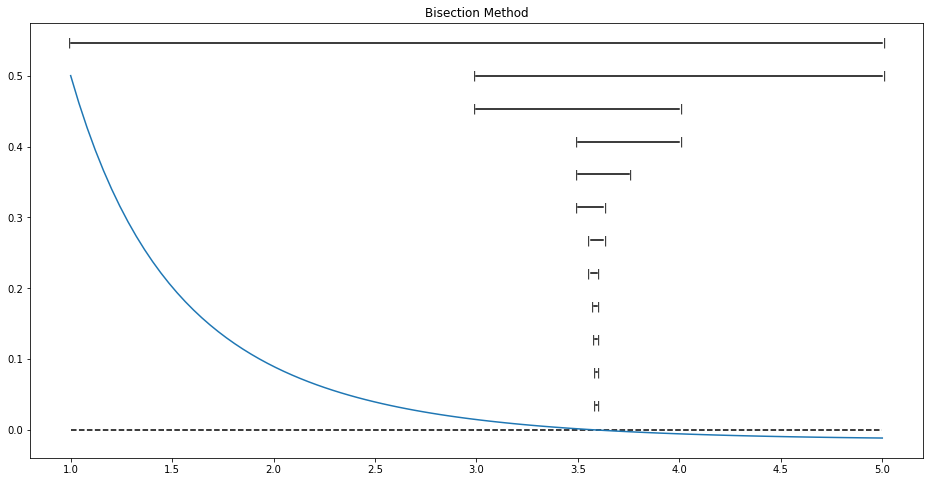

In [ ]:
# f = lambda x: x**3 - 4*x**2 + 18*x -115
f = lambda x: (1 + 1/x - np.log(x))/(1+x)**2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
bisection_root_finder(f, a=1, b=5, steps=12, ax=ax)
_ = ax.set_title('Bisection Method')
print('(x,                 f(x)                  )')
print(bisection_root_finder(f, a=1, b=5, steps=50))
print(bisection_root_finder(f, a=1, b=5, steps=100))
print(bisection_root_finder(f, a=1, b=5, steps=150))

*This example is inspired by Chapter 2.1 **Univariate Problems** of Givens and Hoetings (pages 22-26), Chapter 3.3 [**Interval Bisection Method**](https://www.tf.uni-kiel.de/matwis/amat/comp_math/kap_1/backbone/r_se19.html) in J. Carstensen and J. M. Wagner's [**Computer Matematics**](https://www.tf.uni-kiel.de/matwis/amat/comp_math/), and the **Bisection Method** Section in Chapter 6.1 **Finding Roots of Equations** of Gentle (pages 246-248). [Errata Warning: on page 25 Givens and Hoeting report that bisection works for continuous $g'$, which is true; but, more correctly (and generally) bisection works for finding zeros of continuous functions $g$; and in Algorithm 6.2 **Bisection to Find a Root of an Equation** on page 247, Gentle does not point out that there is more numerical precision in the updates $a+(b-a)/2$ or $b-(b-a)/2$ rather than $(a+b)/2$ as pointed out by Givens and Hoetings on page on page 25.]*

<a name="cell-opt-fx-bisection-considerations"></a>

### Initializations, Limitations, and Convergence ([Return to TOC](#cell-TOC-opt)) 
---

The previously introduced root-finding with ***bisection*** (for ***continuous*** functions) can be used to find the ***stationary points*** of $g(z) = f'(z)$ rather than the ***roots*** of $f(z)$, i.e., to solve
$f'(z)=0$ rather than $f(z)=0$. 

Here are some generally instructive considerations characterizing ***bisection***:

0. *Accuracy*: root-finding exactness is constrained by the available numeric precision.
1. *Initialization*: zeros cannot be found without initializing $\text{sign}(g(a_0)) \not = \text{sign}(g(b_0))$
2. *Limitation*: a maximum of one zero in the initial interval $[a_0, b_0]$ can be found

3. *Convergence*: since the interval is halved at each step, the width of the interval at step $t$ is

   $$b_t-a_t = 2^{-t}(b_0-a_0)$$

   so that for true root $g(x^*)=0$ where $x^* \in [a_t, b_t]$ 
   
   $$\left|\frac{b_t+a_t}{2} - x^*\right| < \delta \quad \text{ when } \quad 2^{-(t+1)}(b_0-a_0) < \delta \quad \text{ or } \quad t > log_2\left(\frac{(b_0-a_0)}{\delta}\right) + 1$$

  so to reduce $\delta$ by a factor of $10$, which reduces the error by one unit of precision requires

  $$t -1 > log_2\left(\frac{(b_0-a_0)}{\delta/10}\right) =  log_2\left(\frac{(b_0-a_0)}{\delta}\right) + \log_2(10) $$ 

  an about $\log_2(10) \approx 3.2$ more steps:

  ```
np.log2(10) # 3.321928094887362
```

> The ***bisection method*** is one (of many) ***braketing methods***.  Another, generally faster, ***braketing method*** method is known as the ***Illinois method***.
- The ***Illinois method*** is a generally preferred variant of the ***Regula Falsi*** method which has quite a long [history](https://en.wikipedia.org/wiki/Regula_falsi#History).
- The ***Regula Falsi*** method works just like the ***secant method***, which is discussed as a discrete version of ***Newton's method below***; except, the sequential points are chosen to bracket the solution.

<a name="cell-opt-fx-newton"></a>

## 9.1.1 Newton's Method ([Return to TOC](#cell-TOC-opt)) 
---

Also known as ***Newton-Raphson iteration***, using a first-order Taylor series approximation of $g'$ in the equation of interest

$$\overbrace{0 = g'(x^*)}^{\text{original problem}} \approx g'(x^{(t)}) + (x^*-x^{(t)})g''(x^{(t)}) =0$$

so long as $g''$ exists (and is non-zero at $x^{(t)}$)

$$  x^* = x^{(t)} - \frac{g'(x^{(t)})}{g''(x^{(t)})} \quad \text{ suggests the iterative update } \quad x^{(t+1)} = x^{(t)} + h^{(t)} \quad \text{ with } \quad h^{(t)}=- \frac{g'(x^{(t)})}{g''(x^{(t)})} $$


> Since $g''(x)$ is the (instantaneous) slope of $g'$ at $x$, solving the the first order Taylor series approximation of $g'$ for $0$ simply means following the slope in the direction of the $y=0$ line until hitting it. 
>
> From [Wikipedia's Newton's Method page](https://en.wikipedia.org/wiki/Newton%27s_method), considering $f(x)$ to be $g'(x)$ above:
> ![](https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif)

- [Programming Portfolio Assignment 5 Question 2](#cell-opt) will involve implementing a ***Newton's method***, ***secant method***, ***fixed point iteration*** and some variants on these methods.


> ***Newton's method*** is introduced here in the context of solving $g'(x^*) = 0$ (and thus ends up depending on $g''$); however, ***Newton's method*** more generally simply a ***root-finding*** method based on a ***first-order Taylor series approximation*** of any function $f$ (and not necessarily an approximation of the ***derivative*** of a function $g'$).  This is why, e.g., the wikipedia presentation above introduces ***Newton's method*** without any attention to the $g'(x^*) = 0$ problem.

<a name="cell-opt-fx-newton-conv"></a>

### Order of Convergence $\beta$ ([Return to TOC](#cell-TOC-opt)) 
---

As with ***bisection***, there are important caveats to ***Newton's method*** for finding the ***roots*** of a function $g'$.

0. *Accuracy*: root-finding exactness is constrained by the available numeric precision.

1. *Initialization*: depending on the function $g'$, poor starting values will not lead to convergence.

2. *Limitation*: initialization agnostic convergence is only guaranteed for some functions, e.g., ***twice differentiable convex functions (with roots)***.

3. *Convergence*: a ***second-order Taylor series approximation*** of $g'$ set equal to $0$ gives

   \begin{align*}
  & g'(x^*) \approx \\ 
  & g'(x^{(t)}) + g''(x^{(t)})(x^*-x^{(t)}) + \frac{1}{2}g'''(x^{(t)})(x^*-x^{(t)})^2 =  0\\
  & x^{(t)}-\frac{g'(x^{(t)})}{g''(x^{(t)})} - x^* = (x^*-x^{(t)})^2 \frac{g'''(x^{(t)})}{2g''(x^{(t)})}\\
  & \quad \quad \quad \;x^{(t+1)}-x^* =  (x^{(t)}-x^*)^2 \frac{g'''(x^{(t)})}{2g''(x^{(t)})} \\
  & \frac{\hat \epsilon^{(t+1)}}{(\hat \epsilon^{(t)})^2} = \frac{g'''(x^{(t)})}{2g''(x^{(t)})} \\ 
\Longrightarrow \quad & \lim_{t\rightarrow \infty} \frac{|\hat \epsilon^{(t+1)}|}{|\hat \epsilon^{(t)}|^\beta} = c \quad \text{ where } \beta=2 \text{ and } \underset{\text{assuming convergence}}{ c = \left|\frac{g'''(x^{*})}{2g''(x^{*})}\right|}\\
   \end{align*}

   which is the defintion of ***convergence of order*** $\beta=2$, i.e., ***quadratic convergence***. In ***quadratic convergence*** the precision of the converging answer approximately doubles at each iteration.
   - E.g., $0.1^2 = 0.01$ and $0.01^2 = 0.0001$. 
   
   However, this is only true based on assuming that the ***second-order Taylor series*** closely approximates $g'(x^*)$ which of course depends on $x^{(t)}$ being sufficiently close to $x^*$.  So, ***Newton's method*** will only have this extremely fast convergence when $x^{(t)}$ is in the "radius of convergence" of $x^*$. 
   
   

> Previously we saw ***gradient decent*** which used the simpler update based on the step size factor $\alpha > 0$ (often called the ***learning rate***)
> 
> $$x^{(t+1)} = x^{(t)} - \alpha g'(x^{(t)}) \quad \text{ in place of } \quad  x^{(t)} - g'(x^{(t)})/g''(x^{(t)})$$
> 
> For $g'(x^*) = 0$, the ***Taylor series approximation*** of $g'(x^{(t)})$ at $x^*$ is $\require{cancel}$ 
> 
> \begin{align*}
\cancel{g'(x^*)}^0 + g''(x^*)(x^{(t)}-x^*) \quad \text{ so } \quad x^{(t+1)}-x^* & = {} x^{(t)} - \alpha g'(x^{(t)}) - x^*\\
& \approx {} x^{(t)} - \alpha g''(x^*)(x^{(t)}-x^*) - x^*\\
& = {} (x^{(t)}-x^*)(1-\alpha g''(x^*))
\end{align*}
> 
> and
>
> $$\frac{x^{(k+1)}-x^*}{x^{(k)}-x^*} = \frac{\epsilon^{(k+1)}}{(\epsilon^{(k)})^\beta} = 1-\alpha g''(x^*) \quad \text{ where } \quad \beta=1$$
> 
> which is the defintion of ***convergence of order*** $\beta=1$, i.e., ***linear convergence***. So ***gradient decent*** has ***linear convergence***. 

   > Since the midpoint of the interval for the ***bisection method*** need not necessarily get closer to the answer every single step, the error of ***bisection method*** does not formally converge to $0$; rather, it is the bracketing interval width that is halved with each step. Letting $\tilde \epsilon$ be the bracketing interval width of the ***bisection method***
   > $$\lim_{n\rightarrow \infty} \frac{|\tilde \epsilon^{(t+1)}|}{|\tilde \epsilon^{(t)}|^1} = \frac{1}{2}$$
   > so the ***bisection method*** behaves like it has ***convergence of order*** $\beta=1$ (i.e., ***linear convergence***), but the convergence of the sequence itself does not have (mathematical) ***convergence of order*** $\beta=1$.
   >
   > Regardless, ***quadratic convergence*** is must faster ***linear convergence***. Recall that for the ***bisection method*** to increase precision by one decimal unit requires about 3.2 iteration steps; whereas, for ***Newton's method*** the precision (approximately) doubles for every single iteration step (assuming the secord order approximation is fairly accurate).

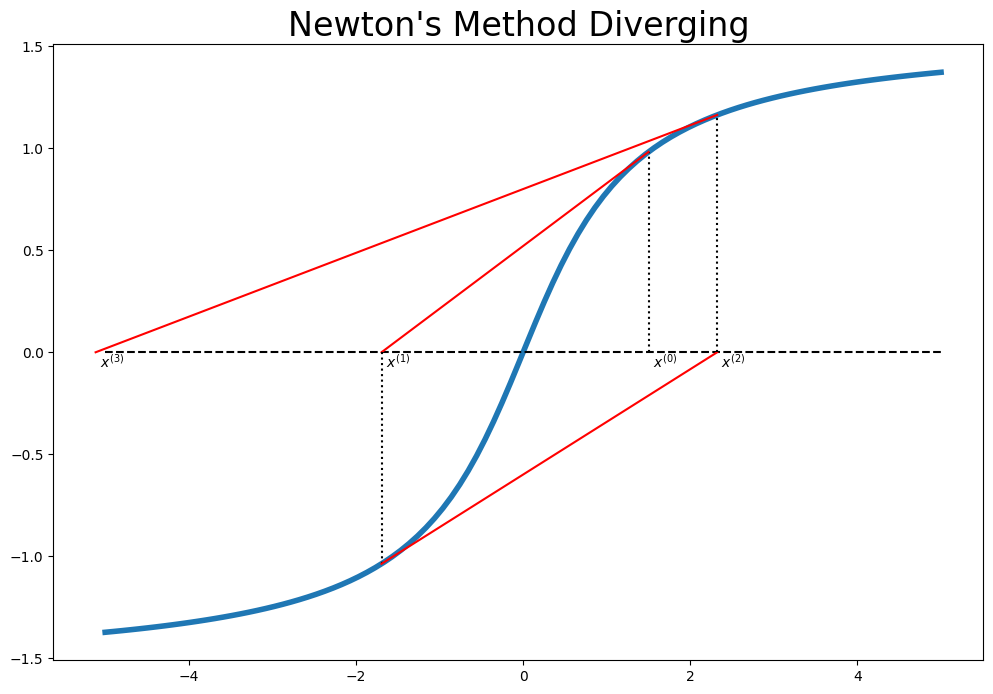

In [ ]:
plt.figure(figsize=(12,8))
plt.style.use('default')

x = np.linspace(-5,5,100)
plt.plot(x, np.arctan(x), linewidth=4)
plt.plot(x,[0]*len(x),'k--')
plt.title("Newton's Method Diverging", fontdict={'fontsize': 24})

x0 = 1.5
x = tf.Variable(x0, dtype=np.float32)
plt.text(x, 0, ' $x^{(0)}$', verticalalignment='top')
for t in range(1,4):

  with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
      y = x*tf.math.atan(x) - 0.5*tf.math.log(1+x**2)
      # dy/dx = arctan(x) # oh, okay
      # ddy/dxdx = 1/(1+x^2) # oh, nice
      # but who cares to remember this when
      # tf can just numerically differentiated it

    # Compute the gradient inside the outer `t2` context manager
    # which means the gradient computation is differentiable as well.
    dy_dx = t1.gradient(y, x)
      
  # https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients    
  d2y_dx2 = t2.gradient(dy_dx, x)

  x_t = tf.Variable(x - dy_dx/d2y_dx2)
  plt.plot([x, x], [0,dy_dx], 'k:')
  plt.plot([x,x_t], [dy_dx,0], c='r')
  plt.text(x_t, 0, ' $x^{('+str(t)+')}$', verticalalignment='top')
  x = x_t

*This example was inspired by [this figure](http://amsi.org.au/ESA_Senior_Years/imageSenior/2a_numerical_methods_graph_7.png) from [this tutorial](http://amsi.org.au/ESA_Senior_Years/SeniorTopic3/3j/3j_2content_2.html) from the Austalian Mathematical Science Institute, and the discussions regarding convergence in Chapter 2.1.1 **Newton's Method** of the Givens and Hoeting **Computational Statistics** textbook (pages 27-29).*

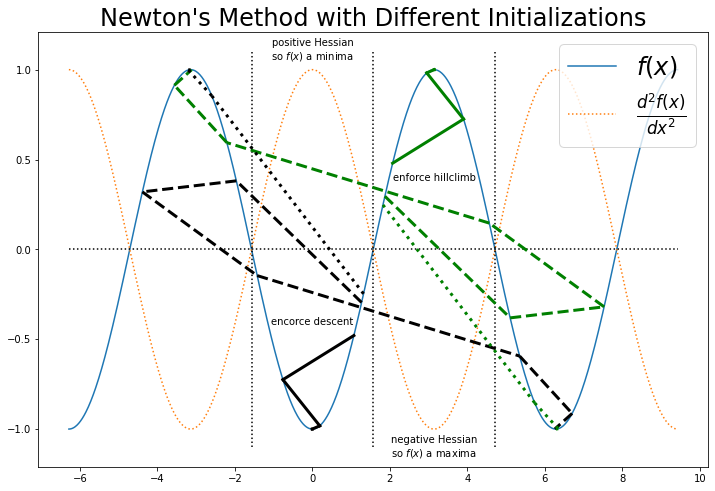

In [ ]:
f = lambda x: -np.cos(x)
dfdx = lambda x: np.sin(x)
d2fdx2 = lambda x: np.cos(x)

x = np.linspace(-2*np.pi,3*np.pi,1000)
plt.figure(figsize=(12,8))
plt.plot(x,f(x), label='$f(x)$')
plt.plot(x,d2fdx2(x), ':', label='$\\frac{d^2f(x)}{dx^2}$')
plt.legend(fontsize=24)
plt.title("Newton's Method with Different Initializations",
          fontdict={'fontsize': 24}) 
plt.plot(x, 0*x, 'k:')
plt.plot([np.pi/2]*2, [-1.1,1.1], 'k:')
plt.plot([-np.pi/2]*2, [-1.1,1.1], 'k:')
plt.plot([1.5*np.pi]*2, [-1.1,1.1], 'k:')

plt.text(0, 1.11, 'positive Hessian\nso $f(x)$ a minima', 
         horizontalalignment='center', verticalalignment='center')
plt.text(2*np.pi/2, -1.1, 'negative Hessian\nso $f(x)$ a maxima', 
         horizontalalignment='center', verticalalignment='center')
plt.text(2*np.pi/2, .4, 'enforce hillclimb', 
         horizontalalignment='center', verticalalignment='center')
plt.text(0, -.4, 'encorce descent', 
         horizontalalignment='center', verticalalignment='center')

for x,style in zip([np.pi/2-.5, np.pi/2+.5, 
              np.pi/2-.3, np.pi/2+.3, 
              np.pi/2-.25, np.pi/2+.25], ['k','g','k--','g--','k:','g:']):
  for i in range(6):#0
    alpha=1#.1
    x_t = x - alpha*dfdx(x)/(d2fdx2(x)-0)
    plt.plot([x,x_t], [f(x),f(x_t)], style, linewidth=3)
    x = x_t

<a name="cell-opt-fx-newton-like-ascent"></a>

### Ensuring Monotonic Iteration and Convergence ([Return to TOC](#cell-TOC-opt)) 

---

Taking inspiration from ***gradient descent***, adjusting ***Netwon's Method*** to a ***Newton-like method*** with step size factor (often called a ***learning rate***) $\alpha$ 

$$x^{(t+1)} = x^{(t)} - \frac{g'(x^{(t)})}{g''(x^{(t)})} \quad \text{ to } \quad  x^{(t+1)} = x^{(t)} - \alpha \frac{g'(x^{(t)})}{g''(x^{(t)})}$$

can ensure monotonically decreasing iteration from $g(x^{(t)})$ to $g(x^{(t+1)})$. If $g''(x^{(t)})>0$ then $\alpha > 0$ to ensure the change has the same sign as $g'(x^{(t)})$; otherwise, if $g''(x^{(t)})<0$ then $\alpha > 0$.

- If iteration is not monotonic then the choice of $\alpha$ can be viewed as a ***line search method*** where the magnitude of change is reduced to ensure monotonic iteration. 

Using the familar ***first order Taylor series approximation*** of $g'$ at $x^*$
\begin{align*}
x^{(t+1)} - x^* & = {} x^{(t)} - \alpha \frac{g'(x^{(t)})}{g''(x^{(t)})} - x^*\\
& \approx {} x^{(t)} - \alpha \frac{g''(x^*)(x^{(t)}-x^*)}{g''(x^{(t)})} - x^*\\
& = {} (x^{(t)} - x^*)\left(1 - \alpha \frac{g''(x^*)}{g''(x^{(t)})}\right)
\end{align*}

so 

$$(\underbrace{x^{(t+1)} - x^*}_{\epsilon^{(t+1)}}) < (\underbrace{x^{(t)} - x^*}_{\epsilon^{(t)}}) \quad \text{ if } \quad \left(1 - \alpha \frac{g''(x^*)}{g''(x^{(t)})}\right) < 1$$

The choice of $\alpha$ thus controls the "radius of convergence" and the speed of convergence.

<a name="cell-opt-fx-newton-mulit"></a>

### Newton's Method for Mulitivariate Functions ([Return to TOC](#cell-TOC-opt)) 

---

For ***scalar valued multivariate functions*** $g(x)$, where $x$ is a vector in ${\rm I\!R}^d$ but $g(x)$ is scalar valued, the update for ***Newton's Method*** is

$$x^{(t+1)} = x^{(t)} - \left[H_{g(x)}(x^{(t)})\right]^{-1}\nabla_xg(x^{(t)})\quad \text{ in place of } \quad x^{(t+1)} = x^{(t)} - \frac{g'(x^{(t)})}{g''(x^{(t)})}$$

which will depend on the ***condition*** of $H_{g(x)}(x^{(t)})$. The method itself is derived from the multivariate generalization of the ***second order Taylor series expansion***

> $$\begin{align*}
g(x^*) \approx {} & g(x^{(t)}) + (x^*- x^{(t)})^T\nabla_x g(x^{(t)}) + \frac{1}{2}(x^*- x^{(t)})^T H_{g(x)}(x^{(t)})(x^*- x^{(t)})\\
\nabla_{x^*}g(x^*) \approx {} & \nabla_{x^*}\left[ g(x^{(t)}) + (x^*- x^{(t)})^T\nabla_x g(x^{(t)}) + \frac{1}{2}(x^*- x^{(t)})^T H_{g(x)}(x^{(t)})(x^*- x^{(t)}) \right]\\
= {} & \nabla_x g(x^{(t)}) + H_{g(x)}(x^{(t)})(x^*- x^{(t)}) = 0\\ 
\Longrightarrow x^{(t+1)} = {} &  x^{(t)} - \left[H_{g(x)}(x^{(t)})\right]^{-1} \nabla_x g(x^{(t)}) 
\end{align*}$$

And, of course, rather than actually inverting the Hessian $H$ matrix, the direction of the update is calculated by solving for $d$ in $H_{g(x)}(x^{(t)})\,d= \nabla_x g(x^{(t)})$.




<a name="cell-opt-fx-newton-mulit-conv"></a>

### Ensuring Monotonic Iteration and Convergence ([Return to TOC](#cell-TOC-opt)) 

---

> ***Newton-like updates*** that include a step size factor $\alpha>0$ of the form 
>
> $$x^{(t+1)} = x^{(t)} - \alpha \left[H_{g(x)}(x^{(t)})\right]^{-1}\nabla_x g(x^{(t)}) $$
> 
> are of interest because while updates from ***Newton's method*** move towards $x^*$ such that $\nabla_x g(x^*) = 0$, this does not imply that $g(x^{(t+1)})$ is decreasing or increasing relative to  $g(x^{(t)})$.  However, if the Hessian is positive (negative) definite, then for some small $\alpha > 0$ all eigenvalues of the inverse Hessian are nonnegative (nonpositive) and so the signs of $\left[H_{g(x)}(x^{(t)})\right]^{-1}\nabla_x g(x^{(t)})$ will match $\nabla_x g(x^{(t)})$ and hence $g(x^{(t+1)})$ will decrease (increase) monotonically relative to $g(x^{(t)})$.

Using the ***first order multivariate Taylor series approximation*** 
at $x^*$ such that $\nabla_x g(x^{*}) = 0$, 

$$\nabla_x g(x^{(t)}) \approx \cancel{\nabla_x g(x^{*})}^0 + J_{\nabla_xg(x)}(x^{*})(x^{(t)}-x^{*}) = H_{g(x)}(x^{*})(x^{(t)}-x^{*})$$

(where the approximation can be removed with the [multivariate mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem)), it follows that 

\begin{align*} 
x^{(t+1)} - x^* & = {} x^{(t)} - \alpha \left[H_{g(x)}(x^{(t)})\right]^{-1}\nabla_x g(x^{(t)}) - x^* \\
& \approx {} x^{(t)} - \alpha \left[H_{g(x)}(x^{(t)})\right]^{-1}J_{\nabla_xg(x)}(x^{*})(x^{(t)}-x^{*}) - x^*\\
& = {} (x^{(t)} - x^*)\left(I - \alpha \left[H_{g(x)}(x^{(t)})\right]^{-1}H_{g(x)}(x^{*})\right)\\
||x^{(t+1)} - x^*|| & \approx {} ||x^{(t)} - x^*\left(I - \alpha \left[H_{g(x)}(x^{(t)})\right]^{-1}H_{g(x)}(x^{*})\right)|| \\
 & \leq {} ||x^{(t)} - x^*|| \left|\left|I - \alpha \left[H_{g(x)}(x^{(t)})\right]^{-1}H_{g(x)}(x^{*})\right|\right| \\
 & = {} ||x^{(t)} - x^*|| \left|\left|I - \alpha M\right|\right| \\
\end{align*}

which shows that 

$$||x^{(t+1)} - x^*|| <  ||x^{(t)} - x^*|| \quad \text{ if } \quad \left|\left|I - \alpha M \right|\right| < 1$$

For the $L_2$ ***induced matrix norm***, $\left|\left| M \right|\right|$ will be the ***maximum singular value*** of $M$. If $M$ is positive definite, then all ***singular values*** $\lambda_\max > \cdots > \lambda_\min > 0$ and

$$\text{if } \quad 0 < \alpha < \frac{2}{\lambda_\max} \quad \text{ then } \quad \left|\left| I - \alpha M \right|\right| < 1$$

and $x^{(t)}$ converges to $x^*$. However, e.g., for $\alpha = \frac{1}{\lambda_\max}$, then $1-\alpha\lambda_\max=0$ but 

$$\left|\left|I - \alpha M\right|\right| = 1-\alpha\lambda_\min = 1 - \alpha\frac{\lambda_\min}{\lambda_\max} = 1 - \alpha \kappa^{-1}(M)$$

 which is close to $1$ if the ***condition number*** of $M$ is large. Thus, if $$\kappa(M)>>1$$ then $x^{(t)}$ converges to $x^*$ slowly.

<a name="cell-opt-fx-secant"></a>

## 9.1.2 The Secant Method ([Return to TOC](#cell-TOC-opt)) 

---

An alternative to ***Newton's method*** for univariate optimization, i.e., finding the roots of $g'(x) = 0$, is the ***secant method*** 

$$x^{(t+1)} = x^{(t)} - \frac{g'(x^{(t)})(x^{(t)}-x^{(t-1)})}{g'(x^{(t)})-g'(x^{(t-1)})} \quad \text{ which replaces } \quad x^{(t+1)} = x^{(t)} - \frac{g'(x^{(t)})}{g''(x^{(t)})}$$

by specifing a sequence of two initial values $x^{(-1)}$ and $x^{(0)}$ and then substituting the ***discrete difference*** approximation of the second derivative $g''$ at $x^{(t)}$ 

  $$g''(x^{(t)}) \approx \frac{g'(x^{(t)})-g'(x^{(t-1)})}{x^{(t)}-x^{(t-1)}} $$

1. *Initialization*: the ***secant method*** requires two initial values, and as an approximation to ***Newton's method***, the ***secant method*** obviously shares similar characteristics; namely, convergence cannot be achieved with poor starting values.

2. *Limitation*: the ***secant method*** similarly shares the limited convergence guarantees of ***Newton's method***; namely, convergence is only guaranteed for some functions,
e.g., ***twice differentiable convex functions (with roots)***.

3. *Convergence*: the ***secant method*** can be shown to have a convergence order $\beta = (1+\sqrt{5})/2 \approx 1.62$ (i.e., better than ***linear*** but worse than ***quadratic convergence***), so approximating the derivative causes the ***order of convergence*** $\beta \approx 1.62$ of the ***secant methods*** to be worse than the ***order of convergence*** $\beta = 2$ of ***Newton's Method***. 

  > However,
> - ***Newton's Method*** requires two function evaluations per iteration, i.e., $g'(x^{(t)})$ and $g''(x^{(t)})$
> - but the ***secant methods*** only requires a single function evaluation per iteration because $g'(x^{(t)})$ may be used at step $t$ and reused on step $t-1$
> 
> so the actual computational time requirements of the two methods are actually more competitive than is suggested by the theoretical ***order of convergence***.  This is a "per step cost versus number of steps" tradeoff that is very representative of ***iterative methods***. 

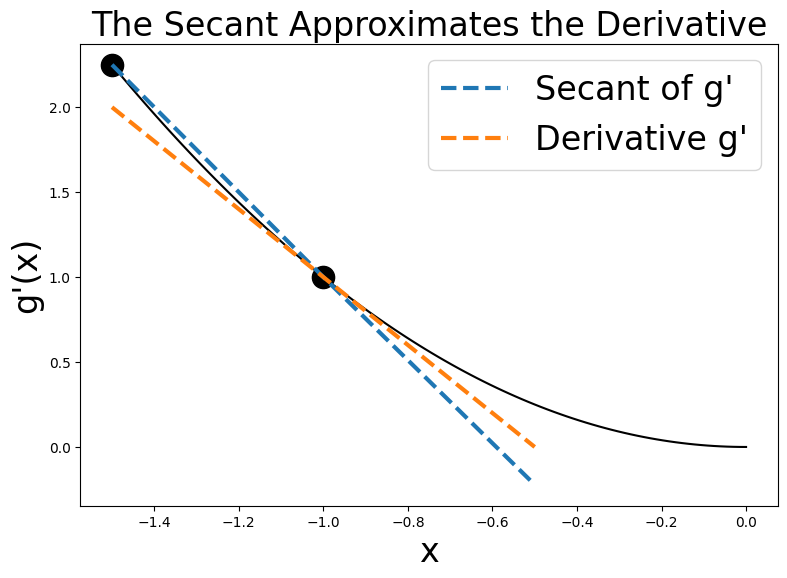

In [ ]:
x = np.linspace(-1.5,0,100)
f = lambda x: x**2

plt.figure(figsize=(9,6))
plt.plot(x, f(x), 'k')
plt.plot(-1,1,'k.', markersize=32)

x0 = -1.5
plt.plot(x0, f(x0), 'k.', markersize=32)
step = 0.5
x1 = x0+step

plt.plot([x0,x1, x1+step], 
         [f(x0),f(x1),f(x1)/f(x0)*(x1+step)], '--', linewidth=3, label="Secant of g'")

plt.plot([x1-step, x1+step], 
         [f(x1)-2*x1*step, f(x1)+2*x1*step], '--', linewidth=3, label="Derivative g'")

plt.ylabel("g'(x)", fontdict={'fontsize': 24})
plt.xlabel("x", fontdict={'fontsize': 24})
plt.title('The Secant Approximates the Derivative',
          fontdict={'fontsize': 24})
_ = plt.legend(fontsize=24)

- - [Programming Portfolio Assignment 5 Question 2](#cell-opt) will involve implementing a ***Newton's method***, ***secant method***, ***fixed point iteration*** and some variants on these methods.


<a name="cell-opt-fx-mvsecant"></a>

### The Secant Method for Scalar Mulitivariate Functions ([Return to TOC](#cell-TOC-opt)) 

---

Generalizing to ***scalar valued multivariate functions***, the ***secant method*** alters ***Newton's method*** from

$$x^{(t+1)} = x^{(t)} - \left[H_{g(x)}(x^{(t)})\right]^{-1}\nabla_xg(x^{(t)}) \quad \text{ to } \quad x^{(t+1)} = x^{(t)} - \left[\begin{array}{c}\frac{\nabla_xg(x^{(t-1)} + e_1x^{(t)}_1 - e_1x^{(t-1)}_1 )^T - \nabla_xg(x^{(t-1)} )^T }{x_1^{(t)}-x_1^{(t-1)}}\\\vdots\\
\frac{\nabla_xg(x^{(t-1)} + e_ix^{(t)}_i - e_ix^{(t-1)}_i)^T - \nabla_xg(x^{(t-1)})^T }{x_i^{(t)}-x_i^{(t-1)}}\\\vdots\\
\frac{\nabla_xg(x^{(t-1)} + e_dx^{(t)}_d - e_dx^{(t-1)}_d )^T - \nabla_xg(x^{(t-1)})^T }{x_d^{(t)}-x_d^{(t-1)}}
\end{array}\right]^{-1}\nabla_xg(x^{(t)}) $$

which avoids calculating the ***Hessian*** $H_{g(x)}(x^{(t)})$; but, each row of the approximating matrix requires a distinct 
***gradient*** $\nabla_xg$ evaluation, which does not offer any computational reuse shortcuts as in the case of the ***univariate secant method***.

> The ***Broyden class*** of ***quasi-Newton methods*** [(Section 3.3.1)](#cell-opt-fx-quasi-newton) use discrete approximiations of the Hessian $M^{(t)} \approx H_{g(x)}(x^{(t)})$ which satisfy a ***secant condition*** at each step 
>
> $$ \nabla_{x}g(x^{(t)}) - \nabla_{x}g(x^{(t-1)}) = M^{(t)}(x^{(t)} - x^{(t-1)})$$
>
> > i.e., for the ***univariate secant method***,
> >
> > $$ \frac{g'(x^{(t)}) - g'(x^{(t-1)})}{(x^{(t)} - x^{(t-1)})} = g''(x^{(t)})$$
>
> and which are also computationally inexpensive to update to $M^{(t+1)}$.

<a name="cell-opt-fx-fixedpoint"></a>

## 9.1.3 Fixed-Point Iteration ([Return to TOC](#cell-TOC-opt)) 

---

The function $f(x) = x + g'(x)$ admits a ***fixed-point iteration algorithm*** for finding the roots of $g'$ since

$$x^* = f(x^*) \quad \Longleftrightarrow \quad g'(x^*)=0 $$

This means that the ***function iteration***

$$x^{(t+1)} = f(x^{(t)}) = x^{(t)} + g'(x^{(t)})$$

will converge if $x^{(t)}$ is in a ***contractive*** region of $f$.

> E.g., for $g(x) = -\frac{1}{3}x^3$, the ***fixed-point iteration algorithm*** $x^{(t+1)} = f(x^{(t)}) = x^{(t)} + g'(x^{(t)}) = x^{(t)} - (x^{(t)})^2$ converges for any $x^{(0)} \in [0,1]$.

The ***order of convergence*** of a ***fixed-point iteration algorithm*** $f(x^{(t)}) = x^{(t)} + h(x^{(t)})$ depends on the specific form of $h(x^{(t)})$.

> Both ***Newton's method*** (***order of convergence*** $\beta=2$) and the ***secant method*** (***order of convergence*** $\beta=1.62$) are ***fixed-point iteration algorithms*** since
> - if $x^{(t+1)} = x^{(t)} - \frac{g'(x^{(t)})}{g''(x^{(t)})} \quad$ then $\quad x^{(t+1)} = x^{(t)} \Longleftrightarrow g'(x^{(t)})=0$
> - if $x^{(t+1)} = x^{(t)} - \frac{g'(x^{(t)})(x^{(t)}-x^{(t-1)})}{g'(x^{(t)})-g'(x^{(t-1)})}\quad$ then $\quad x^{(t+1)} = x^{(t)} \Longleftrightarrow g'(x^{(t)})=0$
>
> and thus convergence of both ***Newton's method*** and the ***secant method*** depend on initializing a starting point within a ***contractive*** region.

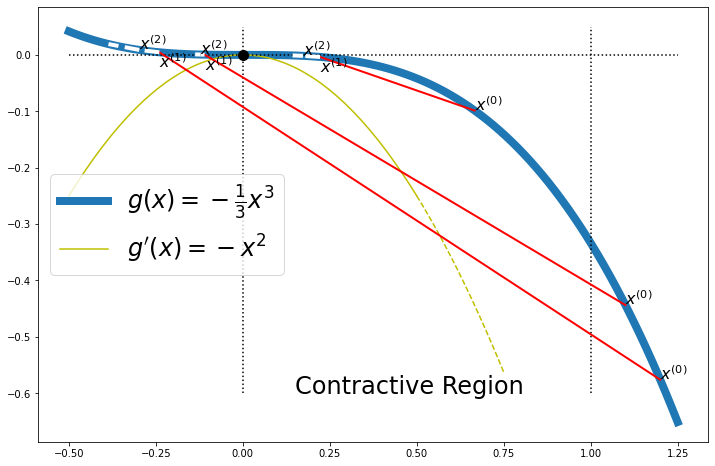

In [ ]:
f = lambda x: -x**3/3
dfdx = lambda x: -x**2

x = np.linspace(-.5,1.25,100)
plt.figure(figsize=(12,8)) # plt.style.use('default')
plt.plot(x, f(x), linewidth=8, label='$g(x) = -\\frac{1}{3}x^3$')
x = np.linspace(-.5,.5,100)
plt.plot(x, dfdx(x), 'y-', label='$g\'(x) = -x^2$')
x = np.linspace(.5,.75,100)
plt.plot(x, dfdx(x), 'y--')
plt.legend(loc='center left', fontsize=24)
plt.plot(0, f(0), 'k.', markersize=20)
plt.plot([0,0], [-.6,.05], 'k:', markersize=20)
plt.plot([1,1], [-.6,.05], 'k:', markersize=20)
plt.plot([-.5,1.25], [0,0], 'k:', markersize=20)
plt.text(.15, -.6,'Contractive Region', size=24)

for x in [1.1, 1.2, 2/3]:
  for i in range(3):
    x_t = x + dfdx(x)
    plt.plot([x,x_t], [f(x),f(x_t)], c=['r','w','w'][i], linewidth=[2,4,4][i], 
             linestyle=['-','--','--'][i])
    if i % 2 == 0:
      plt.text(x, f(x), '$x^{('+str(i)+')}$', size=16)
    else:
      plt.text(x, f(x), '$x^{('+str(i)+')}$', size=16, verticalalignment='top')
    x = x_t

- [Programming Portfolio Assignment 5 Question 2](#cell-opt) will involve implementing a ***Newton's method***, ***secant method***, ***fixed point iteration*** and some variants on these methods.


<a name="cell-opt-fx-fixedpoint-contraction"></a>

### [OMITTED] Contractive Mapping Theorem ([Return to TOC](#cell-TOC-opt))

---

The [***contractive mapping theorem***](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem) states that any function $f$ which is [***contractive***](https://en.wikipedia.org/wiki/Contraction_mapping) over $[a,b]$ has a unique fixed-point $x^* \in [a,b]$ to which ***function iteration*** $x^{(t+1)} = f(x^{(t)})$ will converge.

A function $f(x)$ is ***contractive*** over an interval $R=[a,b]$ if 
1. $x \in R \Longrightarrow f(x) \in R$
2. the ***lipschitz condition*** holds if there is a ***lipschitz constant*** 

   $\lambda \in [0,1) \Longrightarrow |f(x_1)-f(x_2)| \leq \lambda|x_1-x_2|$ for all $x_1,x_2 \in R$

   or equivalently

2. $|f'(x)| \leq \lambda < 1$ for all $x \in R$
   
   e.g., if $f(x) = x + g'(x)$ then $|g''(x) + 1| \leq \lambda < 1$ for all $x \in R$ 

> The function $f(x) = x - x^2$ from the previous example is actually only [***weakly contractive***](https://en.wikipedia.org/wiki/Metric_map) over $R = [0,1]$ since for $g(x) = -\frac{1}{3}x^3$ only ***lipschitz constant*** $\lambda = 1$ satisfies
>
> $$|g''(x)+1| = |1-2x| \leq \lambda $$
>
> for all $x \in R$. Nonetheless, ***weak contraction*** is sufficient for convergence of the ***fixed-point iteration algorithm*** in this case since the root $0=f(0) = g'(0)$ in $R=[0,1]$ is unique.

In [ ]:
# for initial values in [0,1]
x = 2/3
# fixed-point iteration approaches 0
# as n increases
n = 1000000
#xs = np.zeros(n)
for i in range(n):
  x = x - x**2
print("Fixed-point iteration (slowly) approaches root:", x) 

# despite having lipschitz constant 1...
# since as x1 and x2 approach 0 lipschitz constant must increase towards 1
n = 10000
lipschitz_constant = 0
for x1 in np.linspace(0,1,n):
  for x2 in np.linspace(0,1,n):
    if x1 != x2:
      if np.abs((x1-x1**2) - (x2-x2**2))/np.abs(x1-x2) > lipschitz_constant:
        lipschitz_constant = np.abs((x1-x1**2) - (x2-x2**2))/np.abs(x1-x2)
print("Lipschitz constant 1 satisfies all x1, x2 in R:", lipschitz_constant)

Fixed-point iteration (slowly) approaches root: 9.999840556100012e-07
Lipschitz constant 1 satisfies all x1, x2 in R: 0.9998999899989999


As with all methods for finding the roots of a function $g'$, there are several caveats regarding ***fixed-point iteration algorithms***.
1. *initialization*: starting values must be contained in $R=[a,b]$ over which $f$ is ***contractive*** and $f(x^*) = x^* \in R$ implies $g'(x^*)=0$.

2. *limitations*: identifying a function $f$ satisfying the above requirements may not be straightforward.

3. *convergence*: it can be shown that 

   $$|x^*-x^{(t)}| \leq \frac{\lambda^t}{1-\lambda} |x^{(1)}-x^{(0)}|$$ 

   so the smaller the ***lipschitz constant*** satistifying the ***lipschitz condition***, the smaller the error bounds at iteration $t$. Of course however, as noted, the actual ***order of the convergence*** $\beta$ depends on the specific iterating function $f$ in question, e.g., as in this example [here](https://math.stackexchange.com/questions/2754463/determining-the-order-of-convergence-of-fixed-point-interation).


<a name="cell-opt-fx-fixedpoint-scaling"></a>

### [OMITTED] Scaling ([Return to TOC](#cell-TOC-opt))

---

While the form of the ***iterating function*** $f$ itself determines convergence speed

> e.g., for 
> $$g(x) = \frac{1}{2}x^2 + x\log(x) - x \quad \text{ with } \quad g'(x) = x+ \log(x)$$
> the ***fixed-point iteration algorithm*** candidates, i.e., 
> 
> $$f(x)=x \iff g'(x)=0$$ 
>
> - $f(x) = (x+e^{-x})/2\quad$ **converges quickly**
>   > $x = \exp(-x) \; \Longrightarrow \; log(x) = -x \; \Longrightarrow \; x+\log(x) = 0$
> - $f(x) = e^{-x}\quad\quad\quad\;\;\;$ **converges slowly**
>   > $x = \exp(-x) \; \Longrightarrow \; log(x) = -x \; \Longrightarrow \; x+\log(x) = 0$
> - $f(x) = -\log(x)\quad\quad\,$ **fails to converge**
>   > $x = -\log(x) \; \Longrightarrow \; x+\log(x) = 0$


when $g''(x)$ is bounded and does not change sign over $R$, adjusting the ***iterating function***, e.g., 

$$f(x) = x + g'(x) \quad \text{ to } \quad \tilde f(x) = x + \alpha g'(x) $$

may be able to correct a failing ***lipschitz condition*** by adjusting 

$$|g''(x) + 1| \geq 1 \quad \text{ to } \quad |\alpha g''(x) + 1| \leq \lambda < 1$$

thus enabling both convergence and some degree of speed up of the ***fixed point iteration algorithm***. 

<!--
- ***Scaling*** in the context of a ***fixed point iteration algorithm*** is considered in the second part of [Programming Portfolio Assignment 2 Problem 1](#cell-opt).
-->

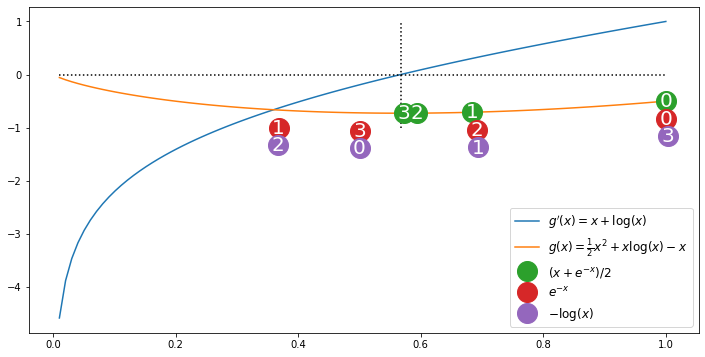

In [ ]:
x = np.linspace(0,1,100)[1:]
g = lambda x: x**2/2 + x*np.log(x) - x
dgdx = lambda x: x + np.log(x)
fs = '$(x+e^{-x})/2$', '$e^{-x}$', '$-\\log(x)$'

plt.figure(figsize=(12,6)) # plt.style.use('default')
plt.plot(x, dgdx(x), label="$g'(x) = x+ \\log(x)$")
plt.plot(x, g(x), label='$g(x) = \\frac{1}{2}x^2 + x\\log(x) - x$')
plt.plot(x,0*x,'k:')
plt.plot([0.56714329]*2,[-1,1],'k:')

K = 4
x_t = np.zeros(K)
g_x_t = np.zeros(K)
for i,f in enumerate([lambda x: (x + np.exp(-x))/2, 
                      lambda x: np.exp(-x),
                      lambda x: -np.log(x)]):
  x_t[0] = 1
  g_x_t[0] = g(1)
  if i == 2:
    x_t[0] = .5
    g_x_t[0] = g(.5)
  for t in range(1,K):
    x_t[t] = f(x_t[t-1])
    g_x_t[t] = g(x_t[t])
  plt.plot(x_t, g_x_t-i/3, '.', markersize=40, label=fs[i])
  for t in range(0,K):
    plt.annotate(str(t), [x_t[t], g_x_t[t]-i/3], c='w', size=20,
                 verticalalignment='center', horizontalalignment='center')
_ = plt.legend(fontsize=12)

*This example was inspired by Section 2.1.4.1 **Scaling** in Chapter 2.4.1 **Fixed-Point Iteration** of the Givens and Hoeting **Computational Statistics** textbook (pages 32-34).*

<a name="cell-opt-fx-fixedpoint-mv"></a>

### Fixed-Point Iteration for Multivariate Functions ([Return to TOC](#cell-TOC-opt)) 

---

For multivariate $x$ and $\alpha \neq 0$ and ***positive*** and ***negative definite*** $H_{g(x)}$ and $M$

- $f(x) = x \pm \nabla_x g(x)$ 
- $f(x) = x - \alpha \nabla_x g(x)$ 
- $f(x) = x \pm H_{g(x)}^{-1}\nabla_x g(x)$ 
- $f(x) = x - \alpha H_{g(x)}^{-1}\nabla_x g(x)$
- $f(x) = x \pm M^{-1}\nabla_x g(x)$ 
- $f(x) = x - \alpha M^{-1}\nabla_x g(x)$ 

all provide ***fixed-point iteration algorithms*** for finding the roots of $g'$ since 

$$x^* = f(x^*) \quad \Longleftrightarrow \quad \nabla_x g(x^*)=0$$

because only $0$ times a ***positive*** and ***negative definite*** matrix is $0$.

> When $M$ satisfies the ***secant condition*** 
> 
> $$\nabla_{x}g(x^{(t+1)}) - \nabla_{x}g(x^{(t)}) = M(x^{(t+1)} - x^{(t)})$$
> 
> then
> 
> \begin{align*}
x^{(t+1)} & = {}  x^{(t)} - M^{-1}\nabla_x g(x^{(t)})\\
M(x^{(t+1)} - x^{(t)}) & = {} -\nabla_x g(x^{(t)})\\
\nabla_{x}g(x^{(t+1)}) - \nabla_{x}g(x^{(t)}) & = {} -\nabla_x g(x^{(t)})\\
\nabla_{x}g(x^{(t+1)}) = 0
\end{align*}

<a name="cell-opt-fx-acceleration"></a>

## 9.1.4 [OMITTED] Acceleration ([Return to TOC](#cell-TOC-opt)) 

---

***Linear order of convergence $\beta=1$*** means there is some $r \in (0,1)$ which is the limiting fractional error reduction for each iteration, i.e., 

$$ \lim_{t' \rightarrow \infty} \frac{|x^* - x^{(t+1)}|}{|x^* - x^{(t)}|^1} = r.$$

But then for some state $t'$ for all $t>t'$

$$r \approx \frac{\Delta x^{(t+1)}}{\Delta x^{(t)}} \quad \text{ where } \quad \Delta x^{(t)} = x^{(t+1)} - x^{(t)}$$ 

and $$\frac{\Delta x^{(t+k)}}{\Delta x^{(t)}} = \prod_{j=1}^k \frac{\Delta x^{(t+j)}}{\Delta x^{(t+j-1)}} \approx \prod_{j=1}^kr = r^k$$

> e.g., for the sequence
>
> $$ \cdots \rightarrow 8 \rightarrow 4 \rightarrow  2 \rightarrow 1 \rightarrow \cdots \rightarrow 0$$ 
>
> - $\frac{2-4}{4-8} = \frac{1}{2} = r$  
> - $\frac{1-2}{4-8} = \frac{1-2}{2-4}\frac{2-4}{4-8} = \frac{1}{4} = r^2$
> - etc.

But once this state is achieved, the process can be analytically completed as a geometric series

\begin{align*}
x^* = {} & x^{(t)} +  \sum_{k=0}^{\infty} \Delta x^{(t+k)}
= x^{(t)} +  \sum_{k=0}^{\infty} \Delta x^{(t)} \frac{\Delta x^{(t+k)}}{\Delta x^{(t)}}\\
 \approx {} & x^{(t)} + \underbrace{  \sum_{k=0}^\infty   \Delta x^{(t)}\overbrace{\Big(\frac{\Delta x^{(t+1)}}{\Delta x^{(t)}}\Big)^k}^{r^k}}_{\text{geometric series}}  \\
= {} & 
x^{(t)} + \overbrace{\frac{\Delta x^{(t)}}{1-\frac{\Delta x^{(t+1)}}{\Delta x^{(t)}}}}= x^{(t)} + \frac{(\Delta x^{(t)})^2}{\Delta x^{(t)}-\Delta x^{(t+1)}} \\
= {} & x^{(t)} - \frac{(\Delta x^{(t)})^2}{\Delta^2 x^{(t)}}
\end{align*}

which gives ***Aitken's $\Delta^2$ acceleration*** extrapolation 

$$x^* \approx x^{(t)} - \frac{(x^{(t+1)} - x^{(t)})^2}{(x^{(t+2)} - x^{(t+1)}) - (x^{(t+1)} - x^{(t)})}$$

> ***Aitken's $\Delta^2$ acceleration***, which is  known as ***Steffensen's method*** when applied to ***fixed-point iteration algorithms***
>
>- will speed up geometric-like ***linear convergence*** to ***quadratic convergence***
>
>  > e.g., for some ***fixed-point iteration algorithms*** but not, unfortunately, for the ***bisection method*** since (as discussed at the end [Section 3.2.2](#cell-opt-fx-newton)) its sequences are not technically ***linearly convegent***
>
> - will improve precision  but not necessarily improve ***order of convergence*** when it's already better than ***linearly convergent***
>  > e.g., as with ***Newton's method*** and the ***secant method***.

- ***Acceleration*** in the context of a ***Newton's method*** will considered in the second part of [Programming Portfolio Assignment 2 Problem 1](#cell-opt).